# Imports Tools and Libraries

In [1]:
import os
import warnings
import numpy as np
import pandas as pd

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

# TensorFlow and Keras modules
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, 
                                     GlobalAveragePooling2D, Embedding, LSTM, add, Concatenate, 
                                     Reshape, concatenate, Bidirectional, Layer)
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Configure warnings and visualization aesthetics
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 12})
sns.set_style('dark')


# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

# Load Dataset

In [2]:
image_directory = '/kaggle/input/flickr8k/Images'
captions_df = pd.read_csv("C:/Users/daniy/Downloads/archive (3)/captions.txt")
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# **Visualization**
- Images and their corresponding captions

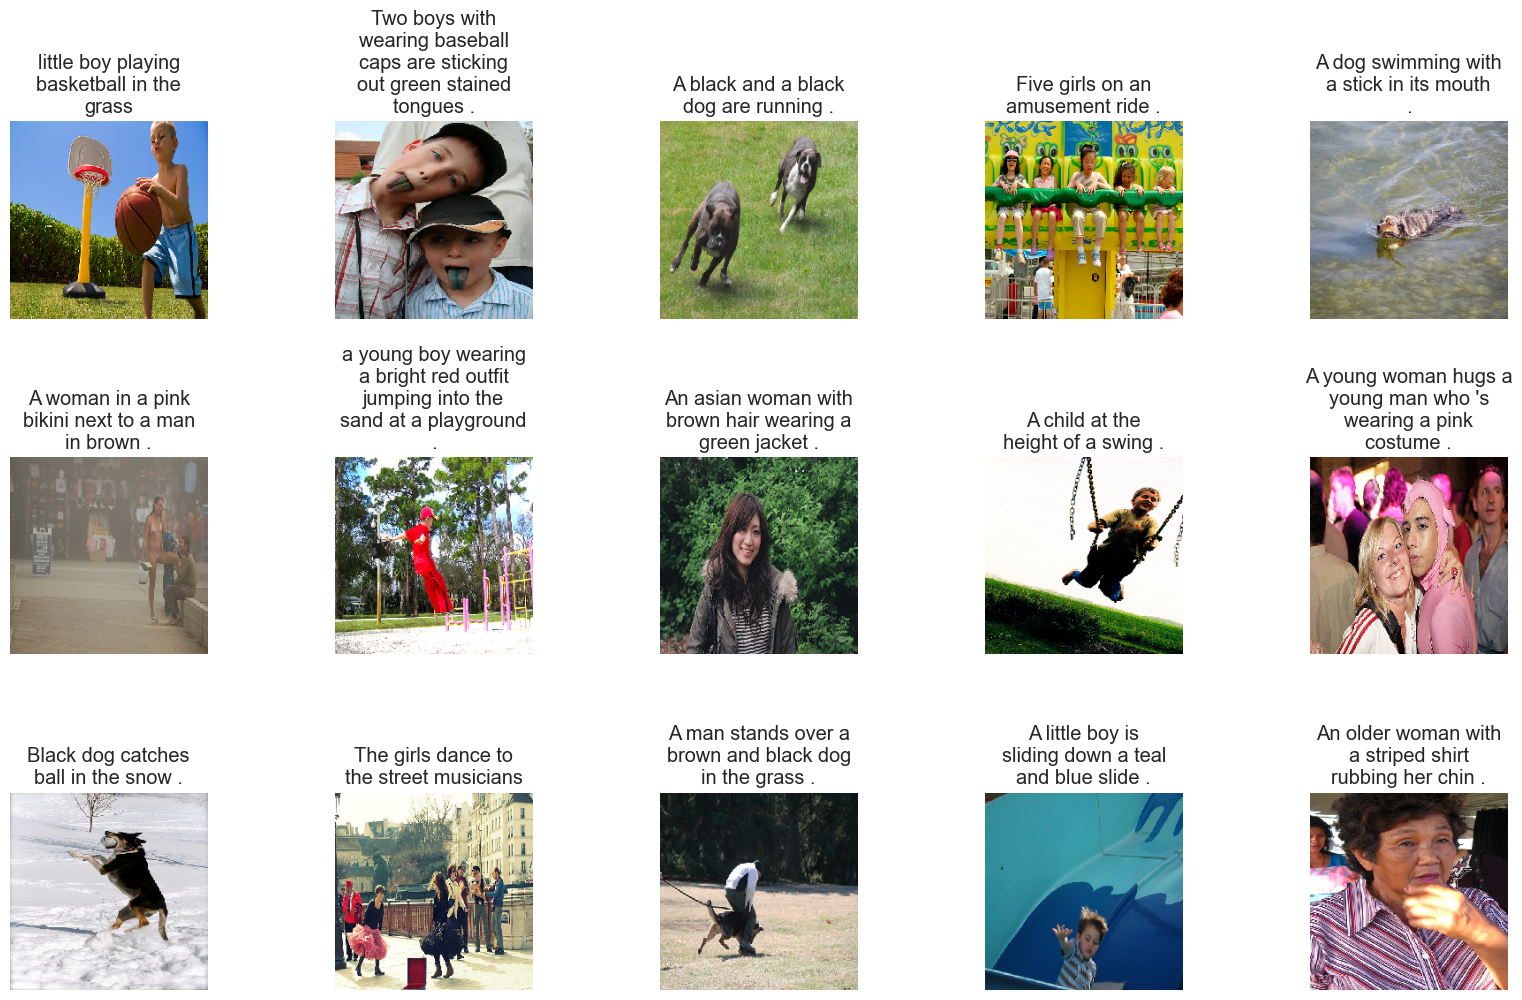

In [3]:
def preprocess_image(image_path, size=224):
    """Loads an image from the given path, resizes it, and scales pixel values."""
    image = load_img(image_path, color_mode='rgb', target_size=(size, size))
    image_array = img_to_array(image) / 255.0  # Normalize to [0, 1]
    return image_array

def plot_sample_images_with_captions(df_sample):
    """Displays 15 image-caption pairs from the provided DataFrame."""
    df_sample = df_sample.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    
    for i in range(15):
        plt.subplot(5, 5, i + 1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)

        img_path = f"C:/Users/daniy/Downloads/archive (3)/Images/{df_sample.image[i]}"
        image = preprocess_image(img_path)
        
        plt.imshow(image)
        plt.title("\n".join(wrap(df_sample.caption[i], 20)))
        plt.axis("off")

plot_sample_images_with_captions(captions_df.sample(15))


# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

<img src='http://zjpnrm2br14wspo448nls17u-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/processing-steps.png' >

In [4]:
# Function to clean and format caption text
def preprocess_captions(df):
    """
    Applies basic preprocessing to image captions:
    - Converts text to lowercase
    - Removes non-alphabetic characters
    - Eliminates extra whitespace
    - Discards single-character words
    - Adds 'startseq' and 'endseq' tokens
    """
    df['caption'] = df['caption'].str.lower()                                 # Convert to lowercase
    df['caption'] = df['caption'].str.replace("[^a-z\s]", "", regex=True)     # Remove special characters and digits
    df['caption'] = df['caption'].str.replace("\s+", " ", regex=True)         # Remove extra spaces
    df['caption'] = df['caption'].apply(lambda x: " ".join([w for w in x.split() if len(w) > 1]))  # Remove single letters
    df['caption'] = df['caption'].apply(lambda x: f"startseq {x} endseq")     # Add sequence tokens
    
    return df

# Apply the preprocessing to the DataFrame
captions_df = preprocess_captions(captions_df)

# Convert cleaned captions into a list
captions_list = captions_df['caption'].tolist()

# Display the first 10 cleaned captions
captions_list[:10]


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [5]:
# Create and fit a tokenizer on the cleaned captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_list)

# Vocabulary size (including a padding index)
vocab_size = len(tokenizer.word_index) + 1

# Determine the length of the longest caption
max_caption_length = max(len(caption.split()) for caption in captions_list)

# Extract unique image filenames
unique_images = captions_df['image'].unique().tolist()
total_images = len(unique_images)

# Split into training and validation sets (85% / 15%)
split_point = round(0.85 * total_images)
train_imgs = unique_images[:split_point]
val_imgs = unique_images[split_point:]

# Filter dataset into training and validation subsets
train_df = captions_df[captions_df['image'].isin(train_imgs)].reset_index(drop=True)
val_df = captions_df[captions_df['image'].isin(val_imgs)].reset_index(drop=True)

# Example: Convert a single caption to a sequence of tokens
example_sequence = tokenizer.texts_to_sequences([captions_list[1]])[0]
example_sequence


[1, 18, 312, 63, 192, 116, 2]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [6]:
# Define the image directory
image_directory = "C:/Users/daniy/Downloads/archive (3)/Images"

# Load the DenseNet201 model and extract features from the penultimate layer
base_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Image size expected by DenseNet
image_size = 224

# Dictionary to store extracted features
image_features = {}

# Loop through all unique image filenames
for img_name in tqdm(captions_df['image'].unique().tolist(), desc="Extracting image features"):
    # Load and preprocess image
    image = load_img(os.path.join(image_directory, img_name), target_size=(image_size, image_size))
    image_array = img_to_array(image) / 255.0  # Normalize pixel values
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Generate feature vector
    feature_vector = feature_extractor.predict(image_array, verbose=0)
    
    # Store the result
    image_features[img_name] = feature_vector


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Extracting image features: 100%|██████████| 8091/8091 [3:03:31<00:00,  1.36s/it]      


# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [18]:
import pandas as pd
import numpy as np
import re

# Load the caption data
data_path = "C:/Users/daniy/Downloads/archive (3)/captions.txt"
data = pd.read_csv(data_path)

# Rename columns if necessary
# If the captions file doesn't have headers, you might need to set them
if data.columns.tolist() == [0]:
    data.columns = ['combined']
    data[['image', 'caption']] = data['combined'].str.split('\t', expand=True)
    data = data[['image', 'caption']]

# Remove any nulls if present
data.dropna(inplace=True)

# Clean and preprocess the captions
def clean_caption(caption):
    caption = caption.lower()
    caption = re.sub(r"[^a-zA-Z]", " ", caption)
    caption = re.sub(r"\s+", " ", caption)
    caption = " ".join([word for word in caption.split() if len(word) > 1])
    return f"startseq {caption} endseq"

data['caption'] = data['caption'].apply(clean_caption)

# Split into training and validation sets based on unique image filenames
images = data['image'].unique().tolist()
split_index = int(0.85 * len(images))

train_images = images[:split_index]
val_images = images[split_index:]

train_df = data[data['image'].isin(train_images)].reset_index(drop=True)
val_df = data[data['image'].isin(val_images)].reset_index(drop=True)

# Display to verify
print(f"Total images: {len(images)}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")


Total images: 8091
Training samples: 34385
Validation samples: 6070


In [21]:
image_path = "C:/Users/daniy/Downloads/archive (3)/Images"  

train_generator = CaptionDataGenerator(
    df=train_df,
    X_col='image',
    y_col='caption',
    batch_size=64,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_caption_length,
    features=image_features
)

validation_generator = CaptionDataGenerator(
    df=val_df,
    X_col='image',
    y_col='caption',
    batch_size=64,
    directory=image_path,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_caption_length,
    features=image_features
)


In [12]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

class CaptionDataGenerator(Sequence):
    """
    Custom data generator for image captioning models.
    Generates batches of image features and corresponding partial sequences.
    """

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        """Shuffle data at the end of each epoch."""
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        """Return total number of batches per epoch."""
        return self.n // self.batch_size

    def __getitem__(self, index):
        """Generate one batch of data."""
        batch_df = self.df.iloc[index * self.batch_size : (index + 1) * self.batch_size]
        X1, X2, y = self._generate_batch_data(batch_df)
        return (X1, X2), y

    def _generate_batch_data(self, batch):
        """Process and return inputs and outputs for one batch."""
        X1, X2, y = [], [], []
        image_files = batch[self.X_col].tolist()

        for image_file in image_files:
            image_feature = self.features[image_file][0]
            captions = batch[batch[self.X_col] == image_file][self.y_col].tolist()

            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq = pad_sequences([seq[:i]], maxlen=self.max_length)[0]
                    out_seq = to_categorical([seq[i]], num_classes=self.vocab_size)[0]

                    X1.append(image_feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)


In [23]:
# Split data into training and validation
images = data['image'].unique().tolist()
split_index = int(0.85 * len(images))

train_images = images[:split_index]
val_images = images[split_index:]

train_df = data[data['image'].isin(train_images)].reset_index(drop=True)
val_df = data[data['image'].isin(val_images)].reset_index(drop=True)


In [24]:
train_generator[0]

((array([[7.8688536e-05, 7.3527970e-04, 1.1396129e-03, ..., 5.6516314e-01,
          2.2899945e-01, 6.9634467e-01],
         [7.8688536e-05, 7.3527970e-04, 1.1396129e-03, ..., 5.6516314e-01,
          2.2899945e-01, 6.9634467e-01],
         [7.8688536e-05, 7.3527970e-04, 1.1396129e-03, ..., 5.6516314e-01,
          2.2899945e-01, 6.9634467e-01],
         ...,
         [1.9476043e-04, 7.0213003e-04, 1.4947478e-03, ..., 2.7233690e-02,
          5.5759460e-01, 3.8916573e-01],
         [1.9476043e-04, 7.0213003e-04, 1.4947478e-03, ..., 2.7233690e-02,
          5.5759460e-01, 3.8916573e-01],
         [1.9476043e-04, 7.0213003e-04, 1.4947478e-03, ..., 2.7233690e-02,
          5.5759460e-01, 3.8916573e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  41],
         [  0,   0,   0, ...,   1,  41,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, LSTM, Dropout, add, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# Define model inputs
image_input = Input(shape=(1920,), name='image_features_input')
text_input = Input(shape=(max_caption_length,), name='caption_input')

# Process image features
image_dense = Dense(256, activation='relu')(image_input)
image_reshaped = Reshape((1, 256))(image_dense)

# Process text input through embedding layer
text_embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=False)(text_input)

# Merge image and text sequences
merged_input = concatenate([image_reshaped, text_embedding], axis=1)
lstm_output = LSTM(256)(merged_input)

# Add dropout and residual connection
x = Dropout(0.5)(lstm_output)
x = add([x, image_dense])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
final_output = Dense(vocab_size, activation='softmax')(x)

# Build and compile the model
caption_model = Model(inputs=[image_input, text_input], outputs=final_output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

# Set up callbacks
checkpoint = ModelCheckpoint(
    filepath='model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-8
)

# Train the model
history = caption_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 871ms/step - loss: 5.6760
Epoch 1: val_loss improved from inf to 4.27126, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 505s 938ms/step - loss: 5.6749 - val_loss: 4.2713 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 881ms/step - loss: 4.3155
Epoch 2: val_loss improved from 4.27126 to 3.94577, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 527s 982ms/step - loss: 4.3154 - val_loss: 3.9458 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - loss: 4.0060
Epoch 3: val_loss improved from 3.94577 to 3.79216, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 531s 925ms/step - loss: 4.0060 - val_loss: 3.7922 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - loss: 3.8087
Epoch 4: val_loss improved from 3.79216 to 3.71023, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 499s 930ms/step - loss: 3.8087 - val_loss: 3.7102 - learning_rate: 0.0

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

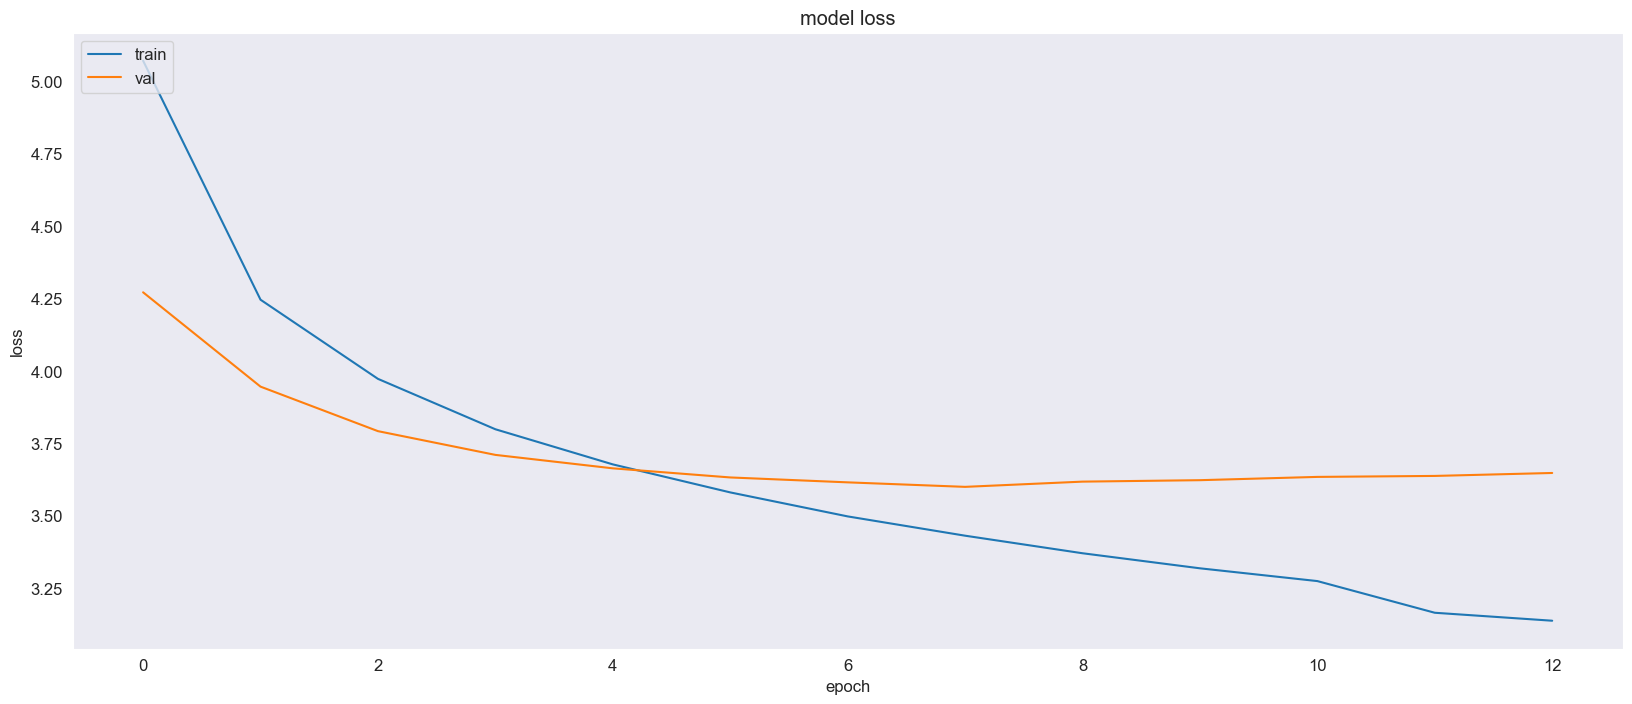

In [28]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [36]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model

# Load DenseNet201 model without the classification head
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features from the last pooling layer (or second-to-last layer as needed)
feature_extractor = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Save the model
feature_extractor.save("feature_extractor.keras")
print("Feature extractor model saved as 'feature_extractor.keras'")


Feature extractor model saved as 'feature_extractor.keras'


In [41]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

In [43]:
# Define the image directory
image_directory = "C:/Users/daniy/Downloads/archive (3)/Images"

# Load the DenseNet201 model and extract features from the penultimate layer
base_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Image size expected by DenseNet
image_size = 224

# Dictionary to store extracted features
image_features = {}

# Loop through all unique image filenames
for img_name in tqdm(captions_df['image'].unique().tolist(), desc="Extracting image features"):
    # Load and preprocess image
    image = load_img(os.path.join(image_directory, img_name), target_size=(image_size, image_size))
    image_array = img_to_array(image) / 255.0  # Normalize pixel values
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Generate feature vector
    feature_vector = feature_extractor.predict(image_array, verbose=0)
    
    # Store the result
    image_features[img_name] = feature_vector


Extracting image features: 100%|██████████| 8091/8091 [53:11<00:00,  2.54it/s]   


In [46]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load DenseNet201 without the top layer
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add GlobalAveragePooling to get a 1920-dim vector
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Final feature extractor model
fe = Model(inputs=base_model.input, outputs=x)


In [47]:
img = load_img(image_path, target_size=(224, 224))
img = img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)

image_features = fe.predict(img, verbose=0)  # Now shape is (1, 1920) ✅


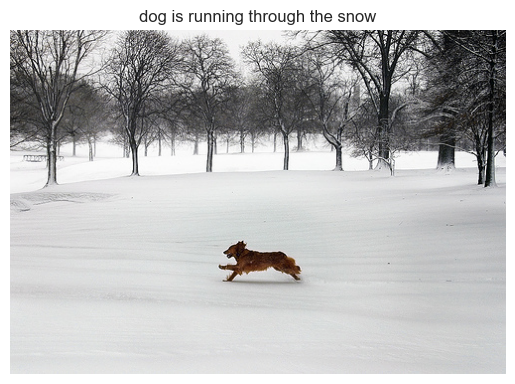

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load the trained caption model
model_path = "model.keras"
caption_model = load_model(model_path)

# Load the feature extractor model
feature_extractor_path = "feature_extractor.keras"
feature_extractor = load_model(feature_extractor_path)

# Set maximum caption length (use your own value if known)
max_length = 34  # Replace with the value used during training

# Image preprocessing and feature extraction
def extract_features(image_path, feature_extractor):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    features = feature_extractor.predict(img, verbose=0)  # Output: (1, 1920)
    return features

# Generate caption from image features
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([photo, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final_caption

# Combine everything and display image with caption
def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34):
    # Load all components
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Extract image features
    photo = extract_features(image_path, feature_extractor)

    # Generate caption
    caption = generate_caption(caption_model, tokenizer, photo, max_length)

    # Display image and caption
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=12)
    plt.show()

# Example usage
image_path = "C:/Users/daniy/Downloads/archive (3)/Images/96973080_783e375945.jpg"
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)


In [51]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
import tensorflow as tf

# Build feature extractor with correct output shape
def build_feature_extractor():
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    input_layer = Input(shape=(224, 224, 3))
    x = base_model(input_layer)
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

# Save the corrected feature extractor
feature_extractor = build_feature_extractor()
feature_extractor.save("feature_extractor.keras")


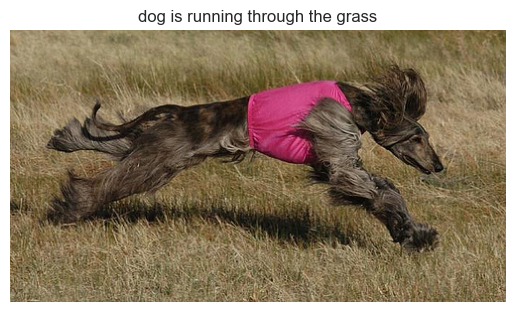

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load the trained caption model
model_path = "model.keras"
caption_model = load_model(model_path)

# Load the feature extractor model
feature_extractor_path = "feature_extractor.keras"
feature_extractor = load_model(feature_extractor_path)

# Set maximum caption length (use your own value if known)
max_length = 34  # Replace with the value used during training

# Image preprocessing and feature extraction
def extract_features(image_path, feature_extractor):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    features = feature_extractor.predict(img, verbose=0)  # Output: (1, 1920)
    return features

# Generate caption from image features
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([photo, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final_caption

# Combine everything and display image with caption
def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34):
    # Load all components
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Extract image features
    photo = extract_features(image_path, feature_extractor)

    # Generate caption
    caption = generate_caption(caption_model, tokenizer, photo, max_length)

    # Display image and caption
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=12)
    plt.show()

# Example usage
image_path = "C:/Users/daniy/Downloads/archive (3)/Images/977856234_0d9caee7b2.jpg"
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)


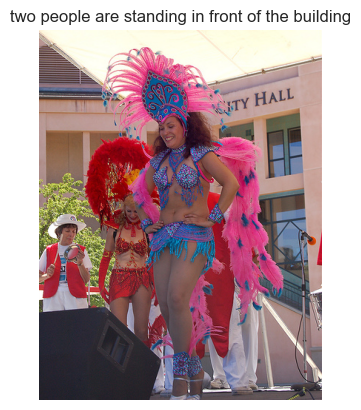

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load the trained caption model
model_path = "model.keras"
caption_model = load_model(model_path)

# Load the feature extractor model
feature_extractor_path = "feature_extractor.keras"
feature_extractor = load_model(feature_extractor_path)

# Set maximum caption length (use your own value if known)
max_length = 34  # Replace with the value used during training

# Image preprocessing and feature extraction
def extract_features(image_path, feature_extractor):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    features = feature_extractor.predict(img, verbose=0)  # Output: (1, 1920)
    return features

# Generate caption from image features
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([photo, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final_caption

# Combine everything and display image with caption
def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34):
    # Load all components
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Extract image features
    photo = extract_features(image_path, feature_extractor)

    # Generate caption
    caption = generate_caption(caption_model, tokenizer, photo, max_length)

    # Display image and caption
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=12)
    plt.show()

# Example usage
image_path = "C:/Users/daniy/Downloads/archive (3)/Images/875731481_a5a0a09934.jpg"
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)


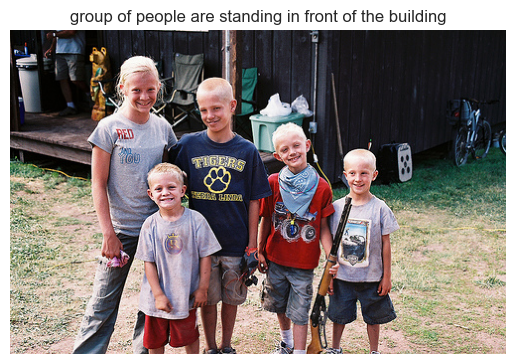

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load tokenizer
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Load the trained caption model
model_path = "model.keras"
caption_model = load_model(model_path)

# Load the feature extractor model
feature_extractor_path = "feature_extractor.keras"
feature_extractor = load_model(feature_extractor_path)

# Set maximum caption length (use your own value if known)
max_length = 34  # Replace with the value used during training

# Image preprocessing and feature extraction
def extract_features(image_path, feature_extractor):
    img = load_img(image_path, target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    features = feature_extractor.predict(img, verbose=0)  # Output: (1, 1920)
    return features

# Generate caption from image features
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        yhat = model.predict([photo, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
    return final_caption

# Combine everything and display image with caption
def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34):
    # Load all components
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Extract image features
    photo = extract_features(image_path, feature_extractor)

    # Generate caption
    caption = generate_caption(caption_model, tokenizer, photo, max_length)

    # Display image and caption
    img = load_img(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=12)
    plt.show()

# Example usage
image_path = "C:/Users/daniy/Downloads/archive (3)/Images/792362827_5ab5281b99.jpg"
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"

generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)
